![uc3m](http://materplat.org/wp-content/uploads/LogoUC3M.jpg)
#### Mount Google Drive

**Carlos González Gamella** 2023-2024

**100364132**

In [ ]:
# If you want to store some models or results into your drive, you might find these lines of code useful
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Change to assignment directory ('ATVAIV/LabSession1' by default)
import os
os.chdir('/content/drive/My Drive/ATVAIV/LabSession1')

Mounted at /content/drive


#### Required libraries for the lab session

In [ ]:
# Numpy
import numpy  as np

# Matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')

# Itertools
import itertools

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F  # useful stateless functions
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

## [!] INSTRUCTIONS FOR THE SUBMISSION OF THE LAB EXERCISES

The objective of this activity is that students strengthen the concepts acquired about Image Classification using DNNs and CNNs.

In order to do the lab session exercises, students have to use Google Colab, execute this notebook for their resolution and answer several brief questions, including both extra code and text cells, if necessary.

**This notebook with the solutions to the lab exercises must be submitted to Aula Global before the 22nd October at 23:59h.**


# LAB SESSION 1
---

# IMAGE CLASSIFICATION WITH DNNs AND CNNs

### APPLICATIONS OF SPEECH, AUDIO, IMAGE AND VIDEO PROCESSING

### MASTER IN TELECOMMUNICATIONS ENGINEERING
### ACADEMIC COURSE 2023/2024



1. INTRODUCTION AND OBJECTIVES

2. DATABASE

> 2.1 PREPARATION

> 2.2 VISUALIZATION

3. MULTILAYER PERCEPTRON

> Module API

> 3.1 NEURAL NETWORK DEFINITION

> 3.2 TRAINING LOOP AND EXECUTION

4. CONVOLUTIONAL NEURAL NETWORKS

> Module API

> 4.1 NEURAL NETWORK DEFINITION

> 4.2 TRAINING LOOP AND EXECUTION

> 4.3 SHOW WHAT HAS BEEN LEARNED BY THE CNN


---
## 1. INTRODUCTION AND OBJECTIVES
---

This lab session makes an introduction to the use of neural networks for image classification.

For that purpose, we will make use of the [PyTorch](https://pytorch.org/) open source machine learning framework. PyTorch is a system for executing dynamic computational graphs over Tensor objects that behave similarly as numpy ndarray. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation.

Moreover, the well-known [CIFAR-10 database](https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 60000 32x32 colour images in 10 classes, will be used. The objective will be to classify these images according to the class they belong to. Therefore, we will solve a multi-class classification problem with 10 classes.


---
## 2. DATABASE
---

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images (5000 images per class) and 10000 test images (1000 images per class). The training set is further divided into 49000 images for training and the remaining 1000 images for validation.

Here are the classes in the dataset, as well as 10 random images from each:

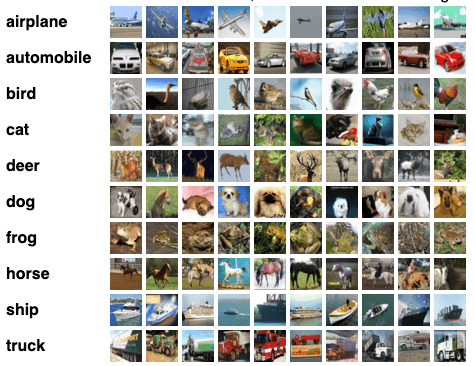


---
#### 2.1 PREPARATION
---

First, we load the CIFAR-10 dataset. PyTorch provides convenient tools to automate this process for us. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In [ ]:
# Parameters (to modify if needed)
NUM_TRAIN = 49000 # Number of training images
b_s = 64 # Batch size

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./dataset', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=b_s,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./dataset', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=b_s,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./dataset', train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=b_s)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


---
#### 2.2 VISUALIZATION
---

---
### [EXERCISE 1]
---
Visualize a batch of images from the training set:

a) Complete the function 'imshow', which receives an image to visualize as input, in order to unnormalize it first, taking into account the normalization applied during the preparation of the database (see Section 2.1)


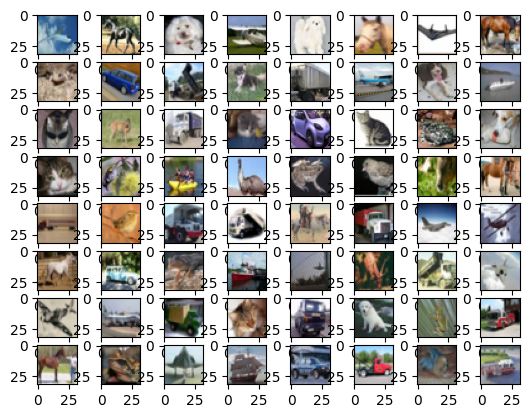

In [ ]:
# Function to unnormalize and show an image
def imshow(img):
    # - - - WRITE YOUR CODE HERE - - - : a) Unnormalize the image to visualize
    std = np.array([0.2023, 0.1994, 0.2010])[:,np.newaxis][:,np.newaxis]
    mean  = np.array([0.4914, 0.4822, 0.4465])[:,np.newaxis][:,np.newaxis]

    img = (img * std) + mean  # reverse the operation Inorm = (Iorig - mu)/sigma
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# Get a batch of training images
dataiter = iter(loader_train)
images, labels = next(dataiter)

# Show images using subplot from Matplotlib
plt.figure()
for i in np.arange(np.shape(images)[0]):
  plt.subplot(8,8,i+1)
  imshow(images[i])
plt.show()

---
## 3. MULTILAYER PERCEPTRON (MLP)
---

Once we have shown and preprocess the database, we will define a simple neural network using [PyTorch](https://pytorch.org/) and the Module API.


---
### 3.1 NEURAL NETWORK DEFINITION
---

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `FCNet`.

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super(FCNet, self).__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`.

After you define your Module subclass, you can instantiate it as an object and call it.

### Fully Connected Network (FCNet)

---
### [EXERCISE 2]
---

Here is an example of a class for a 2-layer fully connected network to learn the image classification problem stated above, which performs the forward pass on a batch of image data.

1) Read and understand the implementation.

2) Use the function 'test_FCNet' to check that the forward pass doesn't crash and produces outputs of the right shape, by running zeros through the network.

3) Answer to the following questions:

a) Take a look at the activation functions in the forward pass. Determine the errors (if any) in the implementation and correct them appropriately. Justify your answer.

**Respuesta:** *En la última capa de la red  es un error poner una función de activación no lineal.Además en problemas de clasificación multiclase, la función de activación recomendada es la softmax. La función CrossEntropyLoss() de Pytorch que utilizaremos en la red ya hace uso de la softmax internamente.*

Debido a que la función tanh es una función no lineal, para la función de activación de las capas ocultas se usará la RELU.*

b) Modify the class in order to add a second hidden layer to the neural network with half the number of units of the first one. The new version of the class will be named 'FCNet3'.

In [ ]:
def flatten(x):
    N = x.shape[0] # read in N(número de imágenes en batch=64), C(#canales = 3), H(altura = 32), W(anchura = 32)
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNet, self).__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fcout = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        x = torch.tanh(self.fc1(x))
        scores = F.relu(self.fcout(x))
        return scores

def test_FCNet():
    input_size = 50
    hidden_size = 42
    num_classes = 10
    x = torch.zeros((64, input_size), dtype=torch.float32)  # minibatch size 64, feature dimension 50
    model = FCNet(input_size, hidden_size, num_classes)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]

test_FCNet()

torch.Size([64, 10])


In [ ]:
class FCNet3(nn.Module):
    ##############################################################
    # - - - WRITE YOUR CODE HERE - - -
    # 3b) Modify the class 'FCNet' in order to add a second hidden layer
    #to the neural network with half the number of units of the first one.
    ##############################################################
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNet3, self).__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, int(hidden_size/2)) # añado una segunda capa oculta, la salida de una es la entrada de la siguiente
        self.fcout = nn.Linear(int(hidden_size/2), num_classes)

    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        x = torch.tanh(self.fc1(x))
        x = F.relu(self.fc2(x))
        scores = self.fcout(x) #Como ya hay una relu, no es necesario volver a hacerlo en la última capa.
        return scores

In [ ]:
def test_FCNet3():
      input_size = 50
      x = torch.zeros((64, input_size), dtype=torch.float32)  # minibatch size 64, feature dimension 50
      model = FCNet3(input_size, 42, 10)
      scores = model(x)
      print(scores.size())  # you should see [64, 10]

test_FCNet3()

torch.Size([64, 10])


---
### 3.2 TRAINING LOOP AND EXECUTION
---

The next step is to define the loss function, the optimization algorithm and all the information we want to show on screen during the training stage.

### **Information to show on screen: Loss and accuracy**

---

When we are dealing with multi-class classification problems as the one considered in this lab session, the ratio 'number of successes/total number of data' (accuracy) is usually shown for the validation or test set, together with the value for the loss.




In [ ]:
def eval_model(loader, model, device = torch.device('cuda')):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    loss = []
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad(): #normalmente uso modelo de descenso por gradiente, haciendo eso hago que no modifique ningún peso
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x) # saca las probabilidades de cada clase
            loss.append(F.cross_entropy(scores, y).data.cpu().numpy())
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        mean_loss = np.mean(loss)
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Loss=%.2f' % mean_loss)
    return acc, mean_loss

### **Training Loop**

We can now set up a basic training loop to train our network.

The training loop takes as input the neural network function; an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks; and the number of epochs to train for.

---
### [EXERCISE 3]
---

In order to compute the loss, several predefined functions are included in PyTorch; you can [read about them here](https://pytorch.org/docs/stable/nn.html#loss-functions).

a) Given the predefined functions in PyTorch, determine two examples of losses which are suitable to solve the CIFAR-10 multi-class image classification problem.

*La función más utilizada en problemas de clasificación multiclase es cross_entropy.
Aunque mirando en la librería de Pytorch hay alguna más como MultiLabelMarginLoss, también había más pero la mayoría de ellas se utilizan en aquellos casos en los que una imagen puede pertenecer a diferentes clases lo que se conoce como un problema multilabel, y esto es algo que la gente confunde aún y hay que diferenciar entre los problemas multi-clase y multi-label, la diferencia principal es que en multi-label una observación puede pertenecer a varias categorías a la vez mientras que en clasificación multi-clase cada observación pertenece a una ÚNICA categoría.*

b) Select one of these loss functions and complete the training loop.



In [ ]:
# Constant to control how frequently we print train loss
print_every = 100

def training_loop(model, optimizer, epochs=1, device = torch.device('cuda')):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)

            loss = F.cross_entropy(scores, y) ### TO COMPLETE

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward() #Calculamos los gradientes

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step() #Modifica los pesos según el gradiente

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc, mean_loss = eval_model(loader_val, model)
                print()

### **Execution**

Now we are ready to run the training loop. We will start training for only one epoch.

---
### [EXERCISE 4]
---

a) Use the constructor of `FCNet3` to define the model. Indicate the input size, the first hidden layer size (remember that the second hidden layer is composed of half of the units of the first one), and number of classes (i.e. output size).

b) We will train the model using Stochastic Gradient Descent (SGD) without momentum. This optimizer has to be defined before the execution.

For further information about other optimization methods, you can [read it here](https://pytorch.org/docs/stable/optim.html).

![fc1](http://2.bp.blogspot.com/-q6l20Vs4P_w/VPmIC7sEhnI/AAAAAAAACC4/g3UOUX2r_yA/s1600/s25RsOr%2B-%2BImgur.gif)

Define the optimizer which tracks all the learnable parameters inside `FCNet3`.

For the moment you don't need to tune any hyperparameters, but you should see model accuracies above 40% in the validation set after training for one epoch.

In [ ]:
hidden_layer_size = 4000
learning_rate = 1e-2
input_size = 3*32*32 #tamaño de imagen el primer término es porque son imágenes RGB (color)
num_classes = 10

model = FCNet3(input_size, hidden_layer_size, num_classes) ### TO COMPLETE
optimizer = optim.SGD(model.parameters(),learning_rate) ### TO COMPLETE

training_loop(model, optimizer, epochs=1)

Iteration 0, loss = 2.3086
Checking accuracy on validation set
Got 116 / 1000 correct (11.60)
Loss=2.30

Iteration 100, loss = 1.9577
Checking accuracy on validation set
Got 353 / 1000 correct (35.30)
Loss=1.90

Iteration 200, loss = 1.6906
Checking accuracy on validation set
Got 379 / 1000 correct (37.90)
Loss=1.81

Iteration 300, loss = 1.6464
Checking accuracy on validation set
Got 406 / 1000 correct (40.60)
Loss=1.75

Iteration 400, loss = 1.7220
Checking accuracy on validation set
Got 410 / 1000 correct (41.00)
Loss=1.71

Iteration 500, loss = 1.6835
Checking accuracy on validation set
Got 421 / 1000 correct (42.10)
Loss=1.67

Iteration 600, loss = 1.5147
Checking accuracy on validation set
Got 433 / 1000 correct (43.30)
Loss=1.65

Iteration 700, loss = 1.7111
Checking accuracy on validation set
Got 435 / 1000 correct (43.50)
Loss=1.62



### **Validation of hyperparameters: Learning Rate and Early Stopping**


---
### [EXERCISE 5]
---

1) Modify the function which defines the training loop ('training_loop') in order to represent, using Matplotlib, the value of the loss and the accuracy for the training and validation sets over epochs. The new version of the function will be named 'training_loop_plot'.

2) Perform the training stage during 10 epochs, using three different learning rate values: 1e-1, 1e-3 and 1e-5. What differences do you observe when applying the different learning rates? Determine an optimal value for the learning rate. Justify your answer.

1. Tasa de aprendizaje 1e-1: Demasiado alta, lo que provoca oscilaciones y posiblemente lleva a la divergencia.
2. Tasa de aprendizaje 1e-3: Parece ser la óptima entre las tres opciones. Proporciona una reducción estable y consistente en la pérdida y una mejora en la precisión.
3. Tasa de aprendizaje 1e-5: Demasiado baja, lo que lleva a un aprendizaje muy lento y posiblemente requiere muchas más épocas para converger.

Basándome en las gráficas y los comportamientos observados:

La tasa de aprendizaje óptima entre las opciones dadas es 1e-3(o 0.001).Esta tasa logra un buen equilibrio entre una convergencia rápida y la estabilidad durante el entrenamiento. La tasa más alta corre el riesgo de sobrepasar mínimos y posiblemente divergir, mientras que la tasa más baja corre el riesgo de una convergencia muy lenta, posiblemente requiriendo un número prohibitivo de épocas para alcanzar un buen modelo.





In [ ]:
def training_loop_plot(model, optimizer, epochs=1, device = torch.device('cuda')):
    ##############################################################
    # - - - WRITE YOUR CODE HERE - - -
    # 1) Modify the function 'training_loop' to represent,
    # using Matplotlib, the value of the loss for the training
    # and validation sets over epochs.

    ##############################################################

    loss_val_list = []
    loss_train_list = []

    meanloss_val_list = []
    meanloss_train_list = []

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = nn.CrossEntropyLoss()
            loss = loss(scores, y) ### TO COMPLETE [COMPLETED]

            loss_train_list.append(loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

        # Save mean_loss values for each epoch
        meanloss_train_list.append(np.mean(loss_train_list))

        acc, mean_loss = eval_model(loader_val, model)
        meanloss_val_list.append(mean_loss)

    # Eval model with Test Set
    acc, mean_loss = eval_model(loader_test, model)

    # Plot mean loss for each epoch and set
    plt.plot(loss_val_list)
    plt.plot(meanloss_train_list, label='Train')
    plt.plot(meanloss_val_list, label='Validation')
    plt.legend(title = 'Data')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Mean Loss over Epochs")
    plt.show()

Training with learning rate: 0.1
Checking accuracy on validation set
Got 468 / 1000 correct (46.80)
Loss=1.52
Checking accuracy on validation set
Got 470 / 1000 correct (47.00)
Loss=1.56
Checking accuracy on validation set
Got 514 / 1000 correct (51.40)
Loss=1.45
Checking accuracy on validation set
Got 492 / 1000 correct (49.20)
Loss=1.59
Checking accuracy on validation set
Got 502 / 1000 correct (50.20)
Loss=1.56
Checking accuracy on validation set
Got 514 / 1000 correct (51.40)
Loss=1.53
Checking accuracy on validation set
Got 524 / 1000 correct (52.40)
Loss=1.58
Checking accuracy on validation set
Got 469 / 1000 correct (46.90)
Loss=2.29
Checking accuracy on validation set
Got 529 / 1000 correct (52.90)
Loss=1.66
Checking accuracy on validation set
Got 514 / 1000 correct (51.40)
Loss=1.83
Checking accuracy on test set
Got 5084 / 10000 correct (50.84)
Loss=1.87


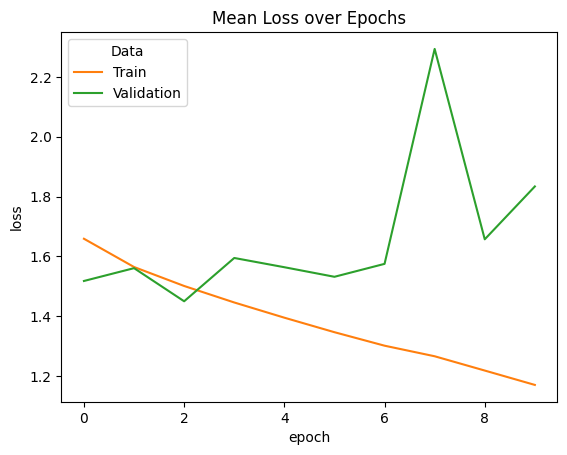

--------------------------------------------------
Training with learning rate: 0.001
Checking accuracy on validation set
Got 327 / 1000 correct (32.70)
Loss=1.94
Checking accuracy on validation set
Got 366 / 1000 correct (36.60)
Loss=1.84
Checking accuracy on validation set
Got 389 / 1000 correct (38.90)
Loss=1.78
Checking accuracy on validation set
Got 402 / 1000 correct (40.20)
Loss=1.73
Checking accuracy on validation set
Got 412 / 1000 correct (41.20)
Loss=1.70
Checking accuracy on validation set
Got 421 / 1000 correct (42.10)
Loss=1.68
Checking accuracy on validation set
Got 431 / 1000 correct (43.10)
Loss=1.65
Checking accuracy on validation set
Got 439 / 1000 correct (43.90)
Loss=1.63
Checking accuracy on validation set
Got 436 / 1000 correct (43.60)
Loss=1.62
Checking accuracy on validation set
Got 445 / 1000 correct (44.50)
Loss=1.59
Checking accuracy on test set
Got 4515 / 10000 correct (45.15)
Loss=1.58


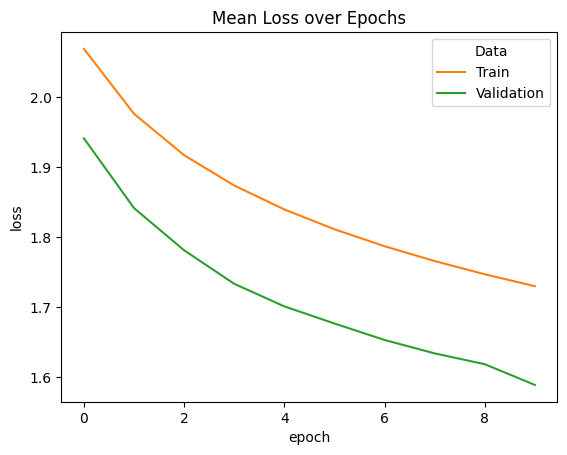

--------------------------------------------------
Training with learning rate: 1e-05
Checking accuracy on validation set
Got 114 / 1000 correct (11.40)
Loss=2.29
Checking accuracy on validation set
Got 127 / 1000 correct (12.70)
Loss=2.28
Checking accuracy on validation set
Got 160 / 1000 correct (16.00)
Loss=2.27
Checking accuracy on validation set
Got 184 / 1000 correct (18.40)
Loss=2.26
Checking accuracy on validation set
Got 200 / 1000 correct (20.00)
Loss=2.25
Checking accuracy on validation set
Got 205 / 1000 correct (20.50)
Loss=2.24
Checking accuracy on validation set
Got 214 / 1000 correct (21.40)
Loss=2.23
Checking accuracy on validation set
Got 224 / 1000 correct (22.40)
Loss=2.22
Checking accuracy on validation set
Got 228 / 1000 correct (22.80)
Loss=2.22
Checking accuracy on validation set
Got 238 / 1000 correct (23.80)
Loss=2.21
Checking accuracy on test set
Got 2371 / 10000 correct (23.71)
Loss=2.21


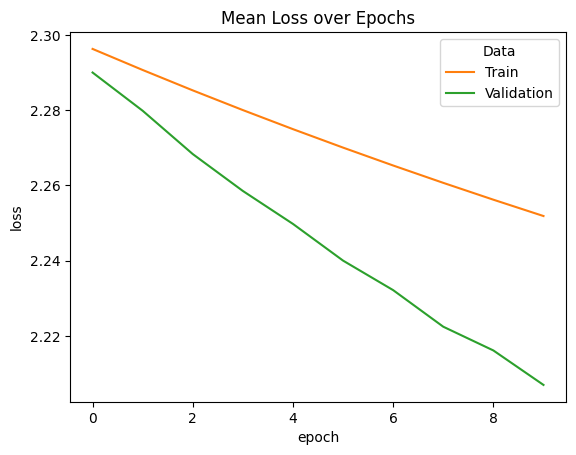

--------------------------------------------------


In [ ]:
##############################################################
# - - - WRITE YOUR CODE HERE - - -
# 2) Perform the training stage during 10 epochs, using three
# different learning rate values: 1e-1, 1e-3 and 1e-5.
##############################################################

# Assuming you have already defined your model architecture elsewhere
# Let's assume it's named MyModel
hidden_layer_size = 4000
learning_rates = [1e-1, 1e-3, 1e-5]
num_epochs = 10
num_classes = 10

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")

    # Initialize your model
    model = FCNet3(input_size, hidden_layer_size, num_classes)  # or however you define it
    # Initialize optimizer with the current learning rate
    optimizer = optim.SGD(model.parameters(), lr)  # You can also use other optimizers like SGD

    # Train your model
    training_loop_plot(model, optimizer, epochs=num_epochs)

    print("-" * 50)



---
## 4. CONVOLUTIONAL NEURAL NETWORKS
---

In the second part of the lab session we are going to deal with Convolutional Neural Networks (CNNs). These networks usually combine convolutional and pooling layers.


## **Module API**

---
### 4.1 NEURAL NETWORK DEFINITION
---

The following figure shows the AlexNet model, composed of 8 layers (5 convolutional layers and 3 FC layers).

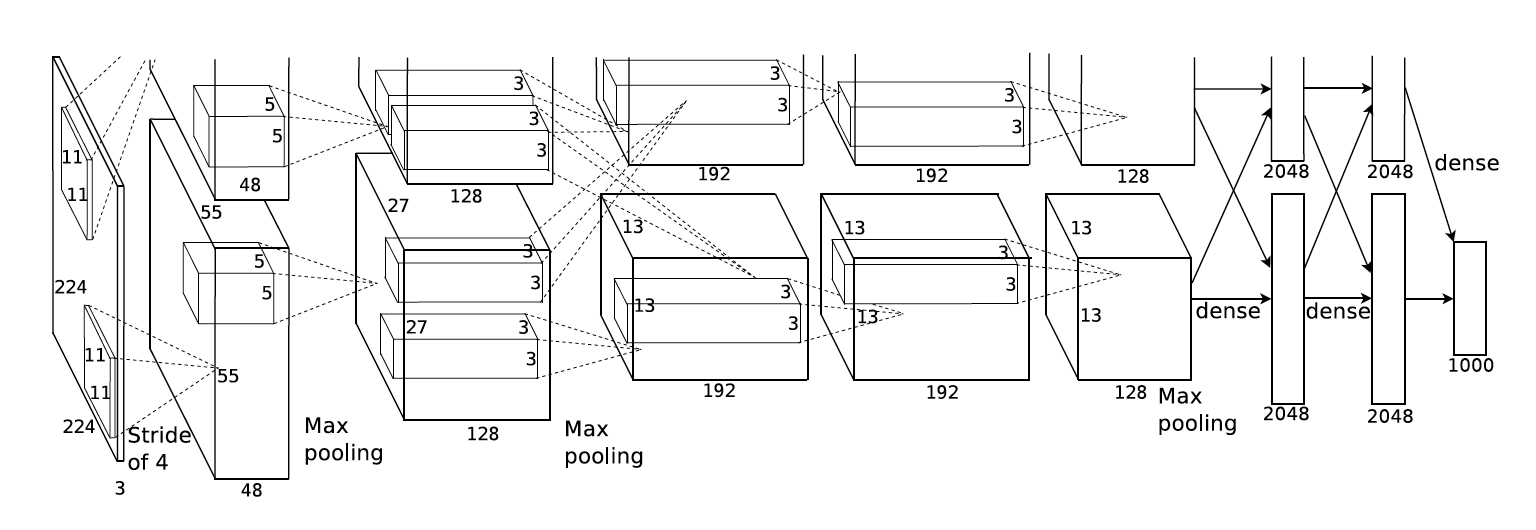

Now we will implement a modified version of AlexNet to perform the multi-class classification problem posed by CIFAR-10 database.

The structure of the modified version to be implemented is the following:

* Input are RGB images of size 32x32x3, as same as in CIFAR-10 database.
* Then, a convolutional layer with 96 filters of size 11x11 is added, whose output results in 96 feature maps of size 32x32.
* After, a maxpooling layer downsamples the 96 feature maps to 16x16.
* Then, a convolutional layer with 256 filters of size 5x5 is added, whose output results in 256 feature maps of size 16x16.
* After, a maxpooling layer downsamples the 256 feature maps to 8x8.
* Then, a convolutional layer with 384 filters of size 3x3 is added, whose output results in 384 feature maps of size 8x8.
* Then, a convolutional layer with 384 filters of size 3x3 is added, whose output results in 384 feature maps of size 8x8.
* Then, a convolutional layer with 256 filters of size 3x3 is added, whose output results in 256 feature maps of size 8x8.
* After, a maxpooling layer downsamples the 256 feature maps to 4x4.
* Finally, 3 dense or FC layers with 4096, 4096 and 10 neurons (output) are included.

Note that behind each convolutional or dense layer (except for the last dense layer) there must be a ReLU activation function.

The only modification with respect to the original structure of the model we will make is the introduction of zero-padding in convolutional layers, in order to preserve the dimensions of the inputs to these layers at the output.


---
### [EXERCISE 6]
---

It's your turn to implement an AlexNet CNN model!

After you implement the AlexNet CNN model, the `test_AlexNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.



In [ ]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class AlexNet(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(AlexNet, self).__init__()
        ########################################################################
        # TODO: Set up the layers you need for a AlexNet CNN with the          #
        # architecture defined above.                                          #
        ########################################################################
        # - - - WRITE YOUR CODE HERE - - -

        self.c1 = nn.Conv2d(in_channel, 96, kernel_size = 11, stride=2, padding=21) # 32x32x3 -> 32x32x96
        self.m1 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0) # 32x32x96 -> 16x16x96

        self.c2 = nn.Conv2d(96 , 256, kernel_size = 5, stride=2, padding=10) #16x16x96 -> 16x16x256
        self.m2 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0) # 16x16x256 -> 8x8x256

        self.c3 = nn.Conv2d(256, 384, kernel_size = 3, stride=2, padding=5) # 8x8x256 -> 8x8x384
        self.c4 = nn.Conv2d(384, 384, kernel_size = 3, stride=2, padding=5) # *8x8x384 -> 8x8x384
        self.c5 = nn.Conv2d(384, 256, kernel_size = 3, stride=2, padding=5) # 8x8x384 -> 8x8x256

        self.m3 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0) # 8x8x256 -> 4x4x256

        self.fc1 = nn.Linear(4*4*256, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fcout = nn.Linear(4096, num_classes)

        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a AlexNet CNN. You          #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # - - - WRITE YOUR CODE HERE - - -

        out = self.c1(x)
        out = F.relu(out)
        out = self.m1(out)

        out = self.c2(out)
        out = F.relu(out)
        out = self.m2(out)

        out = self.c3(out)
        out = F.relu(out)
        out = self.c4(out)
        out = F.relu(out)
        out = self.c5(out)
        out = F.relu(out)
        out = self.m3(out)

        out = flatten(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)

        out = self.fcout(out)
        scores = out

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


def test_AlexNet():
    x = torch.zeros((64, 3, 32, 32), dtype=torch.float32)  # minibatch size 64, image size [3, 32, 32]
    model = AlexNet(in_channel=3, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]

test_AlexNet()

torch.Size([64, 10])


---
### 4.2 TRAINING LOOP AND EXECUTION
---

**Training loop**

You can train the CNN using the training loop defined for the MLP above (see Section 3).

**Execution**

You should now use the Module API to train AlexNet on CIFAR. This should look very similar to training FCNet3!

---
### [EXERCISE 7]
---

a) Use your `AlexNet` class to instantiate a model. Indicate the input size and number of classes (i.e. output size).

b) We will train the model using Stochastic Gradient Descent (SGD) without momentum. Define the optimizer which tracks all the learnable parameters inside `AlexNet`.

c) Peform the training stage during the optimun number of epochs, using an appropriate learning rate.

Los learning_rates más altos (0.04, 0.06, y 0.08) muestran una precisión máxima en el conjunto de validación que es comparativamente más alta que los learning_rates más bajos, pero con unas pérdidas finales en el conjunto de prueba que son también más altas, lo que indica que el modelo podría estar empezando a sobreajustarse.

Con un learning_rate de 0.01 parece ser la más equilibrada en términos de precisión y pérdida en el conjunto de prueba.

Las tasas de aprendizaje muy bajas (0.001 y 0.003) tienen la precisión y la pérdida más bajas en comparación con las otras tasas de aprendizaje, lo que indica que el aprendizaje es más lento y se necesita más entrenamiento para alcanzar una precisión comparable a las tasas más altas.

d) Classify the test set using the model obtained. Determine the loss and the accuracy obtained over it.

El mejor resultado lo otorga la 8 epoch con un learning_rate de 8e-2

Checking accuracy on validation set
Got 670 / 1000 correct (67.00)
Loss=0.99

e) How is the performance compared with the FCNet?

He usado un learning_rate = 1e-2 en 10 épocas.

La loss y el accuracy obtenidos para el conjunto de test con el modelo de *FCNet3* son los siguientes:

- Checking accuracy on validation set
- Got 548 / 1000 correct (54.80)
- Loss=1.28

Analizando los resultados obtenidos, se observa que *AlexNet* se comporta mejor que *FCNet3*. Esto es debido a que *AlexNet* hace uso de capas convolucionales que permiten la extracción de las mejores características de las imágenes de entrada.

Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on validation set
Got 105 / 1000 correct (10.50)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on test set
Got 1000 / 10000 correct (10.00)
Loss=2.30


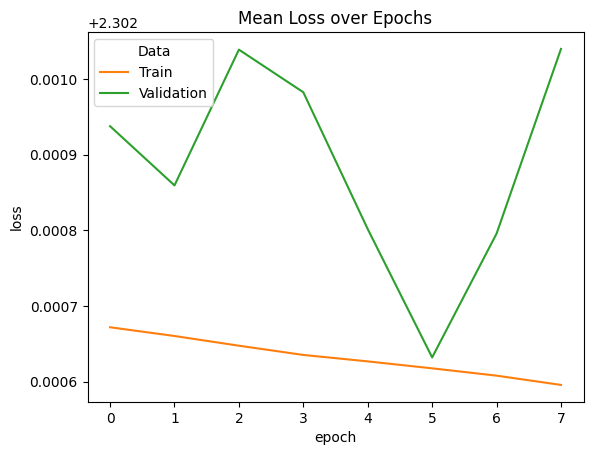

In [ ]:
in_channel = 3
num_classes = 10
momentum = 0
lr = 1e-2
epochs = 8

model = AlexNet(in_channel, num_classes)
optimizer = optim.SGD(model.parameters(), lr)

training_loop_plot(model, optimizer, epochs)

Checking accuracy on validation set
Got 87 / 1000 correct (8.70)
Loss=2.30
Checking accuracy on validation set
Got 87 / 1000 correct (8.70)
Loss=2.30
Checking accuracy on validation set
Got 98 / 1000 correct (9.80)
Loss=2.30
Checking accuracy on validation set
Got 105 / 1000 correct (10.50)
Loss=2.30
Checking accuracy on validation set
Got 144 / 1000 correct (14.40)
Loss=2.30
Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 125 / 1000 correct (12.50)
Loss=2.30
Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 87 / 1000 correct (8.70)
Loss=2.30
Checking accuracy on validation set
Got 90 / 1000 correct (9.00)
Loss=2.30
Checking accuracy on test set
Got 1098 / 10000 correct (10.98)
Loss=2.30


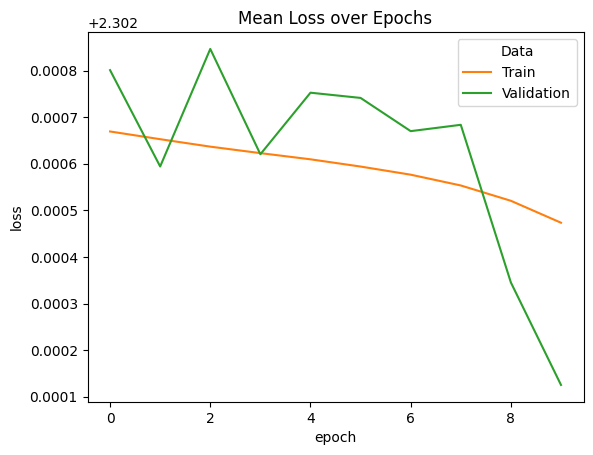

Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 102 / 1000 correct (10.20)
Loss=2.30
Checking accuracy on validation set
Got 87 / 1000 correct (8.70)
Loss=2.30
Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 102 / 1000 correct (10.20)
Loss=2.30
Checking accuracy on validation set
Got 104 / 1000 correct (10.40)
Loss=2.30
Checking accuracy on validation set
Got 154 / 1000 correct (15.40)
Loss=2.28
Checking accuracy on validation set
Got 177 / 1000 correct (17.70)
Loss=2.06
Checking accuracy on validation set
Got 229 / 1000 correct (22.90)
Loss=1.95
Checking accuracy on validation set
Got 270 / 1000 correct (27.00)
Loss=1.84
Checking accuracy on test set
Got 2649 / 10000 correct (26.49)
Loss=1.84


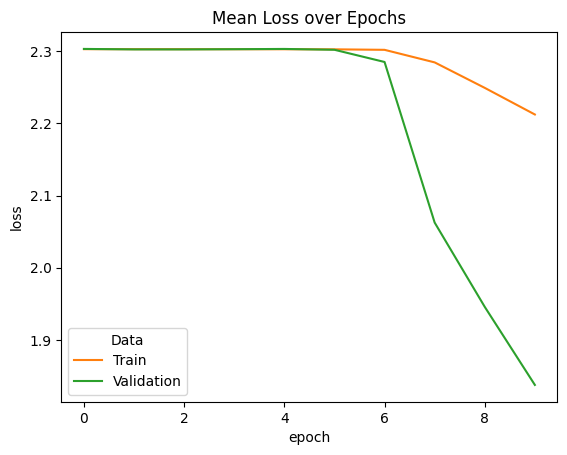

Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on validation set
Got 152 / 1000 correct (15.20)
Loss=2.25
Checking accuracy on validation set
Got 170 / 1000 correct (17.00)
Loss=2.07
Checking accuracy on validation set
Got 269 / 1000 correct (26.90)
Loss=1.81
Checking accuracy on validation set
Got 415 / 1000 correct (41.50)
Loss=1.55
Checking accuracy on validation set
Got 397 / 1000 correct (39.70)
Loss=1.63
Checking accuracy on validation set
Got 567 / 1000 correct (56.70)
Loss=1.24
Checking accuracy on validation set
Got 563 / 1000 correct (56.30)
Loss=1.18
Checking accuracy on validation set
Got 595 / 1000 correct (59.50)
Loss=1.13
Checking accuracy on test set
Got 5758 / 10000 correct (57.58)
Loss=1.17


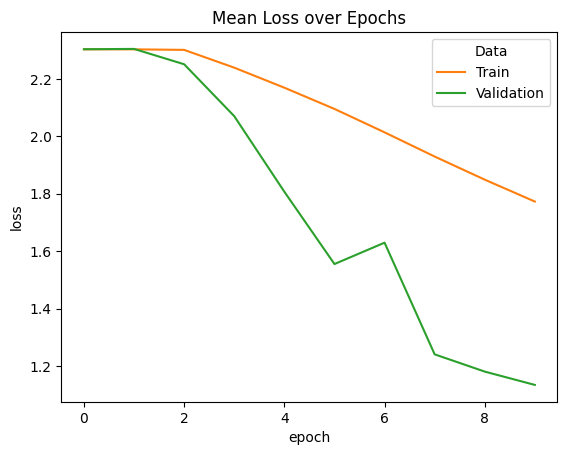

Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on validation set
Got 207 / 1000 correct (20.70)
Loss=2.03
Checking accuracy on validation set
Got 337 / 1000 correct (33.70)
Loss=1.71
Checking accuracy on validation set
Got 389 / 1000 correct (38.90)
Loss=1.62
Checking accuracy on validation set
Got 482 / 1000 correct (48.20)
Loss=1.41
Checking accuracy on validation set
Got 574 / 1000 correct (57.40)
Loss=1.20
Checking accuracy on validation set
Got 607 / 1000 correct (60.70)
Loss=1.15
Checking accuracy on validation set
Got 612 / 1000 correct (61.20)
Loss=1.12
Checking accuracy on validation set
Got 642 / 1000 correct (64.20)
Loss=1.03
Checking accuracy on test set
Got 6253 / 10000 correct (62.53)
Loss=1.08


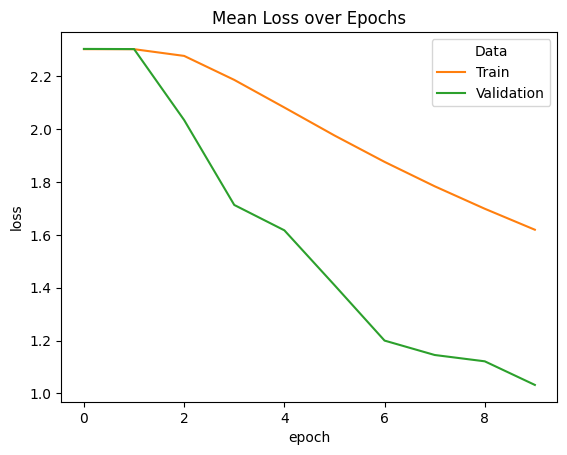

Checking accuracy on validation set
Got 98 / 1000 correct (9.80)
Loss=2.30
Checking accuracy on validation set
Got 221 / 1000 correct (22.10)
Loss=2.12
Checking accuracy on validation set
Got 315 / 1000 correct (31.50)
Loss=1.75
Checking accuracy on validation set
Got 461 / 1000 correct (46.10)
Loss=1.40
Checking accuracy on validation set
Got 502 / 1000 correct (50.20)
Loss=1.34
Checking accuracy on validation set
Got 544 / 1000 correct (54.40)
Loss=1.31
Checking accuracy on validation set
Got 590 / 1000 correct (59.00)
Loss=1.21
Checking accuracy on validation set
Got 633 / 1000 correct (63.30)
Loss=1.06
Checking accuracy on validation set
Got 648 / 1000 correct (64.80)
Loss=1.03
Checking accuracy on validation set
Got 670 / 1000 correct (67.00)
Loss=0.99
Checking accuracy on test set
Got 6554 / 10000 correct (65.54)
Loss=1.06


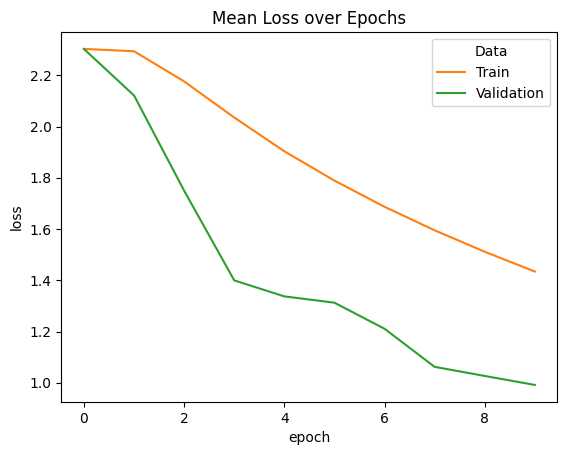

Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on validation set
Got 79 / 1000 correct (7.90)
Loss=2.30
Checking accuracy on test set
Got 1000 / 10000 correct (10.00)
Loss=2.30


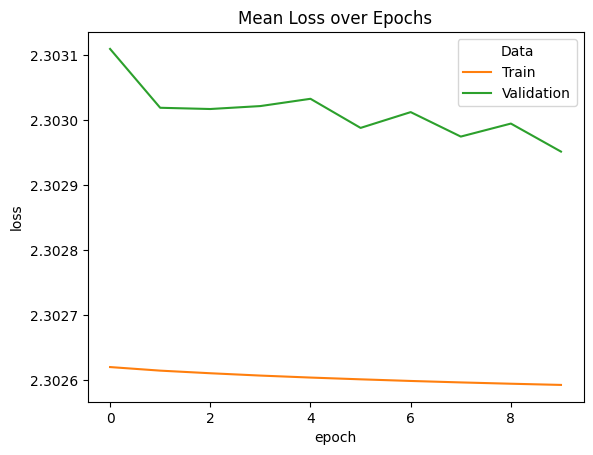

Checking accuracy on validation set
Got 119 / 1000 correct (11.90)
Loss=2.30
Checking accuracy on validation set
Got 119 / 1000 correct (11.90)
Loss=2.30
Checking accuracy on validation set
Got 107 / 1000 correct (10.70)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on validation set
Got 78 / 1000 correct (7.80)
Loss=2.30
Checking accuracy on test set
Got 1000 / 10000 correct (10.00)
Loss=2.30


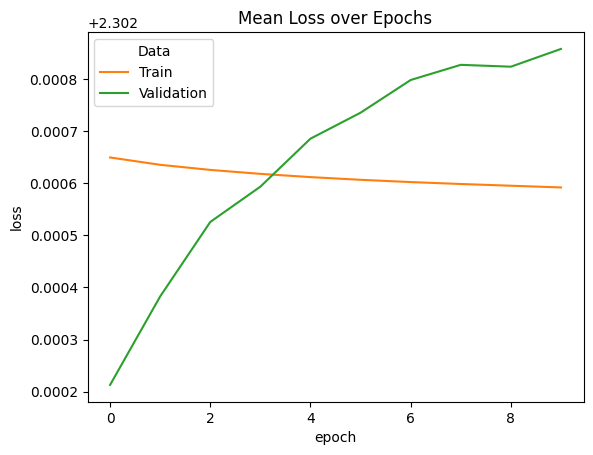

In [ ]:
# Lista de tasas de aprendizaje para probar
learning_rates = [1e-2, 2e-2, 4e-2, 6e-2, 8e-2, 1e-3, 3e-3]
in_channel = 3
num_classes = 10
epochs = 10

# Bucle para probar diferentes tasas de aprendizaje
for learning_rate in learning_rates:
    model = AlexNet(in_channel, num_classes)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    result = training_loop_plot(model, optimizer, epochs)



Training with learning rate: 0.01
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)
Loss=1.60
Checking accuracy on validation set
Got 465 / 1000 correct (46.50)
Loss=1.50
Checking accuracy on validation set
Got 495 / 1000 correct (49.50)
Loss=1.43
Checking accuracy on validation set
Got 501 / 1000 correct (50.10)
Loss=1.38
Checking accuracy on validation set
Got 533 / 1000 correct (53.30)
Loss=1.34
Checking accuracy on validation set
Got 517 / 1000 correct (51.70)
Loss=1.32
Checking accuracy on validation set
Got 544 / 1000 correct (54.40)
Loss=1.30
Checking accuracy on validation set
Got 548 / 1000 correct (54.80)
Loss=1.26
Checking accuracy on validation set
Got 548 / 1000 correct (54.80)
Loss=1.28
Checking accuracy on validation set
Got 545 / 1000 correct (54.50)
Loss=1.26
Checking accuracy on test set
Got 5379 / 10000 correct (53.79)
Loss=1.30


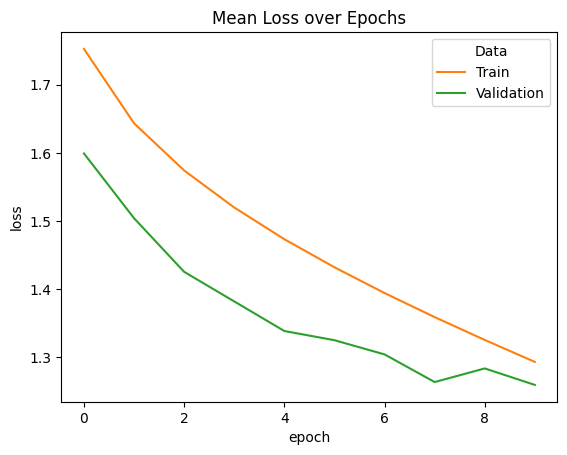

--------------------------------------------------
Training with learning rate: 0.02
Checking accuracy on validation set
Got 456 / 1000 correct (45.60)
Loss=1.54
Checking accuracy on validation set
Got 487 / 1000 correct (48.70)
Loss=1.44
Checking accuracy on validation set
Got 514 / 1000 correct (51.40)
Loss=1.37
Checking accuracy on validation set
Got 538 / 1000 correct (53.80)
Loss=1.31
Checking accuracy on validation set
Got 533 / 1000 correct (53.30)
Loss=1.35
Checking accuracy on validation set
Got 543 / 1000 correct (54.30)
Loss=1.28
Checking accuracy on validation set
Got 555 / 1000 correct (55.50)
Loss=1.26
Checking accuracy on validation set
Got 539 / 1000 correct (53.90)
Loss=1.32
Checking accuracy on validation set
Got 531 / 1000 correct (53.10)
Loss=1.32
Checking accuracy on validation set
Got 563 / 1000 correct (56.30)
Loss=1.28
Checking accuracy on test set
Got 5476 / 10000 correct (54.76)
Loss=1.35


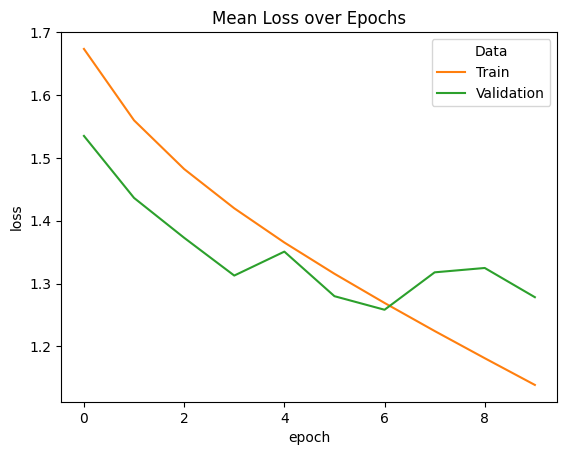

--------------------------------------------------
Training with learning rate: 0.04
Checking accuracy on validation set
Got 459 / 1000 correct (45.90)
Loss=1.49
Checking accuracy on validation set
Got 507 / 1000 correct (50.70)
Loss=1.40
Checking accuracy on validation set
Got 531 / 1000 correct (53.10)
Loss=1.31
Checking accuracy on validation set
Got 530 / 1000 correct (53.00)
Loss=1.34
Checking accuracy on validation set
Got 546 / 1000 correct (54.60)
Loss=1.28
Checking accuracy on validation set
Got 527 / 1000 correct (52.70)
Loss=1.41
Checking accuracy on validation set
Got 536 / 1000 correct (53.60)
Loss=1.45
Checking accuracy on validation set
Got 556 / 1000 correct (55.60)
Loss=1.40
Checking accuracy on validation set
Got 562 / 1000 correct (56.20)
Loss=1.42
Checking accuracy on validation set
Got 547 / 1000 correct (54.70)
Loss=1.65
Checking accuracy on test set
Got 5255 / 10000 correct (52.55)
Loss=1.66


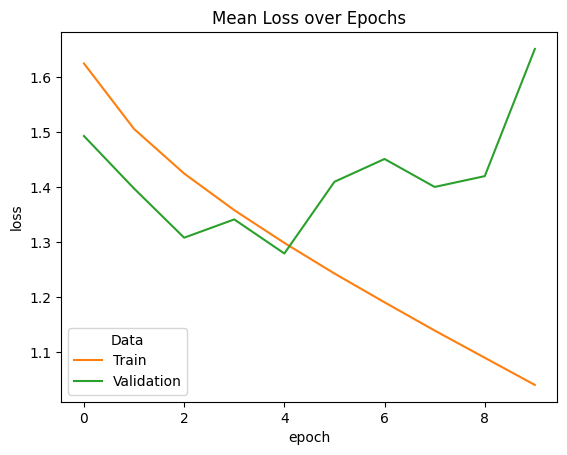

--------------------------------------------------
Training with learning rate: 0.06
Checking accuracy on validation set
Got 449 / 1000 correct (44.90)
Loss=1.56
Checking accuracy on validation set
Got 493 / 1000 correct (49.30)
Loss=1.42
Checking accuracy on validation set
Got 506 / 1000 correct (50.60)
Loss=1.41
Checking accuracy on validation set
Got 528 / 1000 correct (52.80)
Loss=1.34
Checking accuracy on validation set
Got 537 / 1000 correct (53.70)
Loss=1.32
Checking accuracy on validation set
Got 500 / 1000 correct (50.00)
Loss=1.61
Checking accuracy on validation set
Got 531 / 1000 correct (53.10)
Loss=1.46
Checking accuracy on validation set
Got 530 / 1000 correct (53.00)
Loss=1.52
Checking accuracy on validation set
Got 529 / 1000 correct (52.90)
Loss=1.64
Checking accuracy on validation set
Got 546 / 1000 correct (54.60)
Loss=1.68
Checking accuracy on test set
Got 5281 / 10000 correct (52.81)
Loss=1.69


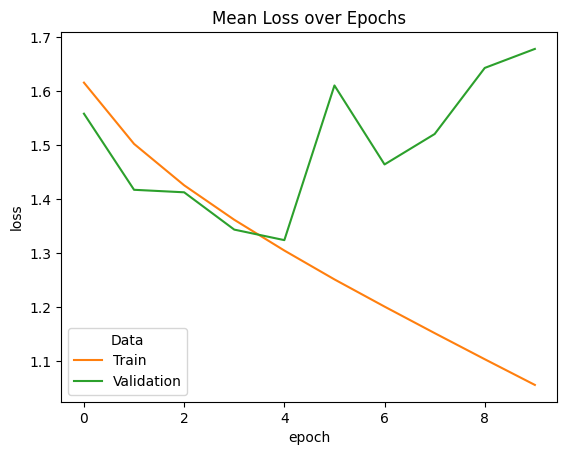

--------------------------------------------------
Training with learning rate: 0.08
Checking accuracy on validation set
Got 411 / 1000 correct (41.10)
Loss=1.60
Checking accuracy on validation set
Got 474 / 1000 correct (47.40)
Loss=1.47
Checking accuracy on validation set
Got 511 / 1000 correct (51.10)
Loss=1.40
Checking accuracy on validation set
Got 487 / 1000 correct (48.70)
Loss=1.60
Checking accuracy on validation set
Got 525 / 1000 correct (52.50)
Loss=1.44
Checking accuracy on validation set
Got 526 / 1000 correct (52.60)
Loss=1.55
Checking accuracy on validation set
Got 534 / 1000 correct (53.40)
Loss=1.64
Checking accuracy on validation set
Got 506 / 1000 correct (50.60)
Loss=1.72
Checking accuracy on validation set
Got 512 / 1000 correct (51.20)
Loss=1.99
Checking accuracy on validation set
Got 520 / 1000 correct (52.00)
Loss=1.88
Checking accuracy on test set
Got 5186 / 10000 correct (51.86)
Loss=1.88


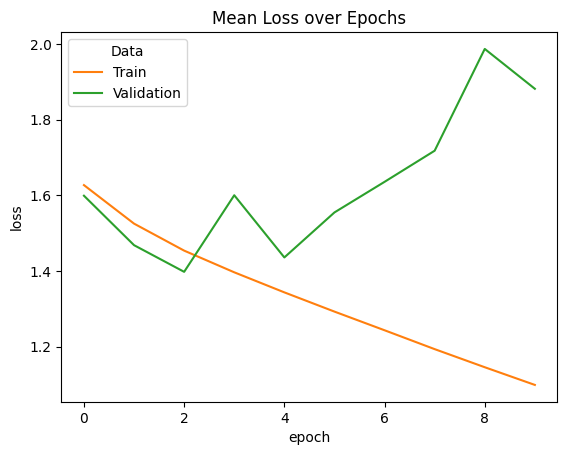

--------------------------------------------------
Training with learning rate: 0.001
Checking accuracy on validation set
Got 345 / 1000 correct (34.50)
Loss=1.94
Checking accuracy on validation set
Got 376 / 1000 correct (37.60)
Loss=1.83
Checking accuracy on validation set
Got 394 / 1000 correct (39.40)
Loss=1.77
Checking accuracy on validation set
Got 407 / 1000 correct (40.70)
Loss=1.73
Checking accuracy on validation set
Got 421 / 1000 correct (42.10)
Loss=1.68
Checking accuracy on validation set
Got 422 / 1000 correct (42.20)
Loss=1.67
Checking accuracy on validation set
Got 430 / 1000 correct (43.00)
Loss=1.64
Checking accuracy on validation set
Got 441 / 1000 correct (44.10)
Loss=1.62
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)
Loss=1.61
Checking accuracy on validation set
Got 441 / 1000 correct (44.10)
Loss=1.59
Checking accuracy on test set
Got 4559 / 10000 correct (45.59)
Loss=1.58


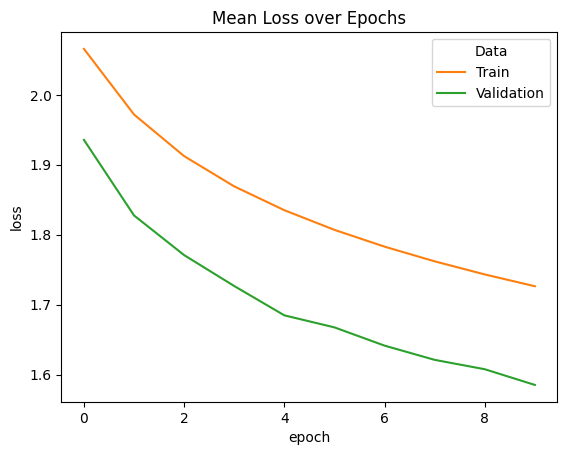

--------------------------------------------------
Training with learning rate: 0.003
Checking accuracy on validation set
Got 378 / 1000 correct (37.80)
Loss=1.78
Checking accuracy on validation set
Got 424 / 1000 correct (42.40)
Loss=1.68
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)
Loss=1.60
Checking accuracy on validation set
Got 460 / 1000 correct (46.00)
Loss=1.56
Checking accuracy on validation set
Got 469 / 1000 correct (46.90)
Loss=1.53
Checking accuracy on validation set
Got 465 / 1000 correct (46.50)
Loss=1.51
Checking accuracy on validation set
Got 478 / 1000 correct (47.80)
Loss=1.47
Checking accuracy on validation set
Got 486 / 1000 correct (48.60)
Loss=1.45
Checking accuracy on validation set
Got 487 / 1000 correct (48.70)
Loss=1.43
Checking accuracy on validation set
Got 495 / 1000 correct (49.50)
Loss=1.41
Checking accuracy on test set
Got 5020 / 10000 correct (50.20)
Loss=1.42


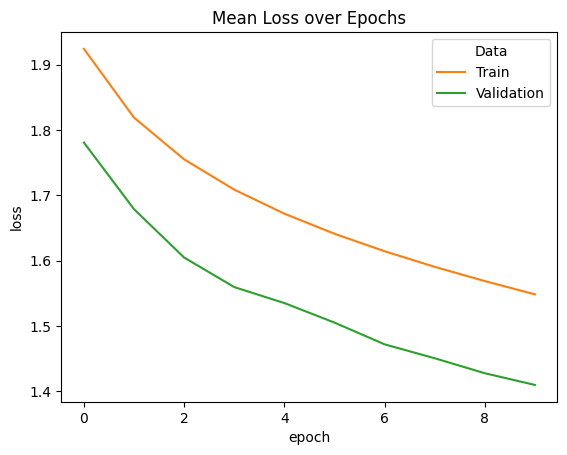

--------------------------------------------------


In [ ]:
# Lista de tasas de aprendizaje para probar
learning_rates = [1e-2, 2e-2, 4e-2, 6e-2, 8e-2, 1e-3, 3e-3]

in_channel = 3
num_classes = 10
hidden_layer_size = 4000
num_epochs = 10
num_classes = 10

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")

    # Initialize your model
    model = FCNet3(input_size, hidden_layer_size, num_classes)  # or however you define it
    # Initialize optimizer with the current learning rate
    optimizer = optim.SGD(model.parameters(), lr)  # You can also use other optimizers like SGD

    # Train your model
    training_loop_plot(model, optimizer, epochs=num_epochs)

    print("-" * 50)

---
### 4.3 SHOW WHAT HAS BEEN LEARNED BY THE CNN
---

Now we will visualize the geometric shapes that the neurons in the first hidden layer have learned to identify, as well as their corresponding activations for some example images. For that purpose, we will use Matplotlib.

---
### Visualize the learned filters and activation maps
---

We have implemented two interesting visualizations for you:

a) Visualize the filters learned in the first convolutional layer.

b) Given a random image as input, visualize the activation maps in the first convolutional layer.

You don't have to code anything for this section. Just execute and understand the code.

In [ ]:
# Definir los parámetros iniciales
in_channel = 3
num_classes = 10

# Instanciar el modelo
model = AlexNet(in_channel,num_classes)
model = model.to(torch.device('cuda'))

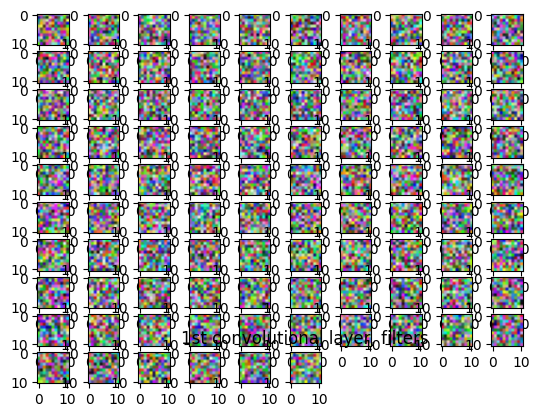

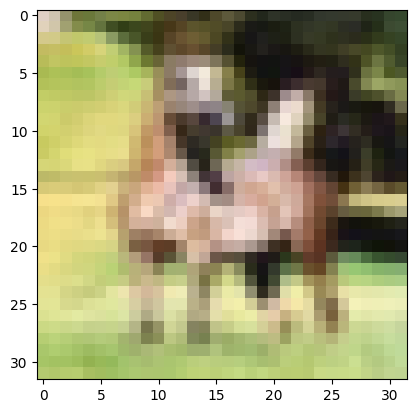

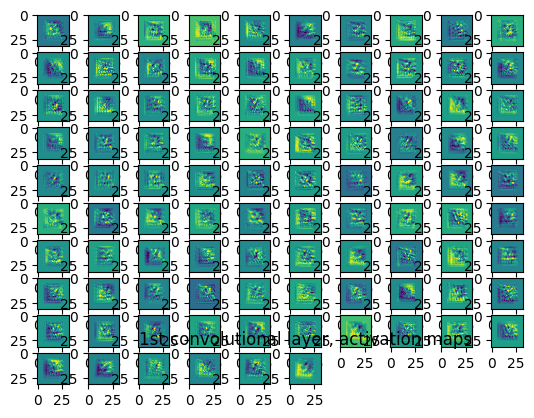

In [ ]:
# a)
# 1st convolutional layer
plt.figure(1)
cont = 1
for i in np.arange(96):
  weight_matrix = model.c1.weight.cpu().detach().numpy()[i]
  weight_matrix = (weight_matrix-np.min(weight_matrix))/(np.max(weight_matrix)-np.min(weight_matrix))
  weight_matrix = np.transpose(weight_matrix,(1,2,0))
  plt.subplot(10,10,cont)
  cont+=1
  plt.imshow(weight_matrix)
plt.title('1st convolutional layer, filters')
plt.show()

# b)
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.c1.register_forward_hook(get_activation('conv1'))
model.c2.register_forward_hook(get_activation('conv2'))
data = next(iter(loader_val))[0][0] # first image in first batch
data = data.unsqueeze_(0).to(device=torch.device('cuda'), dtype=torch.float32)
output = model(data)

# Image
plt.figure(3)
imshow(data[0].cpu())
plt.show()

# 1st convolutional layer
act_conv1 = activation['conv1'].squeeze()
plt.figure(4)
cont = 1
for idx in np.arange(96):
    plt.subplot(10,10,cont)
    cont+=1
    plt.imshow(act_conv1[idx].cpu().numpy())
plt.title('1st convolutional layer, activation maps')
plt.show()